# Lab 6 CNN's

Wyatt Saltzman and Landon Wood
Dr. Larson
CS 7324

In [2]:
# Import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
%matplotlib inline

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.0.3
Numpy version: 1.24.3
Tensorflow version: 2.13.0


## Choose which metric we want to use...

In [3]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
N_CLASSES = 10

tf.random.set_seed(2)
np.random.seed(0)
tf.config.list_physical_devices('GPU')

# Load the data
(X, y), _ = tf.keras.datasets.cifar10.load_data()

# Convert to grayscale
# X = tf.image.rgb_to_grayscale(X).numpy()

# Normalize the data
X = X / 255.0

print('X_train shape:', X.shape)
print('y_train shape:', y.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [4]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Split the data and justify your choice of validation scheme.

In [ ]:
import seaborn as sns
# only use 5000 samples

X = X[:5000]
y = y[:5000]

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (4000, 32, 32, 3)
y_train shape: (4000, 1)


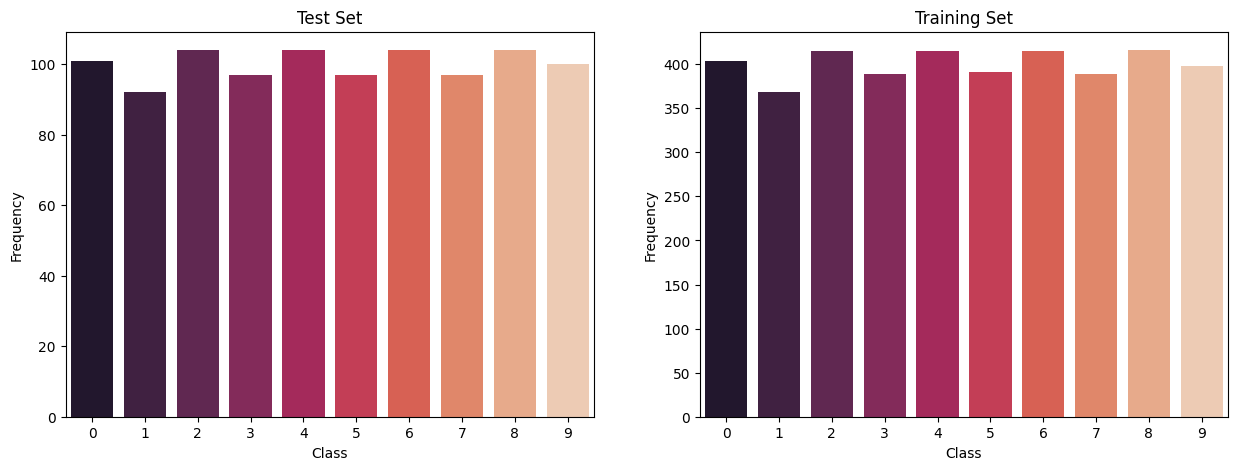

In [7]:
# graph the distribution of the training and test sets
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
test_unique, test_count = np.unique(y_test, return_counts=True)
train_unique, train_count = np.unique(y_train, return_counts=True)
sns.barplot(x=test_unique, y=test_count, palette='rocket', ax=ax[0])
ax[0].set_title('Test Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
sns.barplot(x=train_unique, y=train_count, palette='rocket', ax=ax[1])
ax[1].set_title('Training Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
plt.show()

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

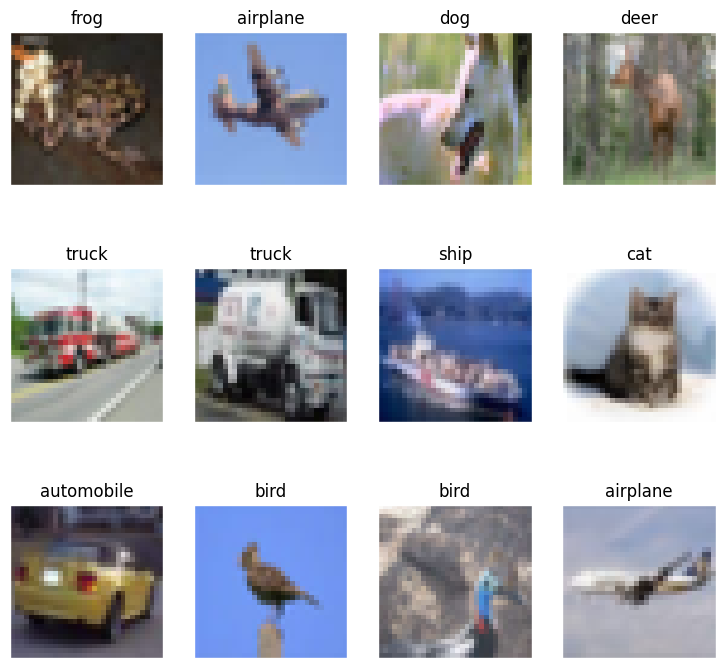

In [9]:
# Plot images
plt.style.use('ggplot')

def plot_gallery(images, titles, h, w, channels=3, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, channels)), cmap=plt.cm.gray)
        plt.title(labels[int(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, IMG_HEIGHT, IMG_WIDTH)

In [27]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# print('Keras version:', keras.__version__)

### Add resoning for data augmentation here...

### CNN 1

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_2 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0       

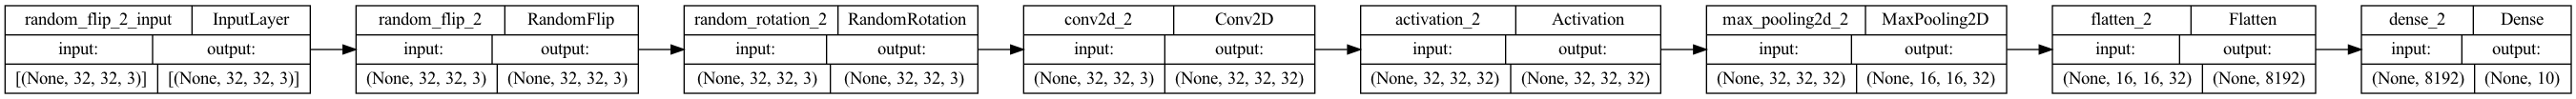

In [21]:
# one hot encode outputs
y_train_ohe = keras.utils.to_categorical(y_train, N_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, N_CLASSES)

# Define the model
cnn = Sequential(name='cnn')
# Add data augmentation layers
cnn.add(RandomFlip('horizontal'))
cnn.add(RandomRotation(0.2))

# Add convolutional layers
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn.add(Flatten())
cnn.add(Dense(N_CLASSES, activation='softmax'))

# Build the model
cnn.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn.summary())

# Plot the model
plot_model(
    cnn, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

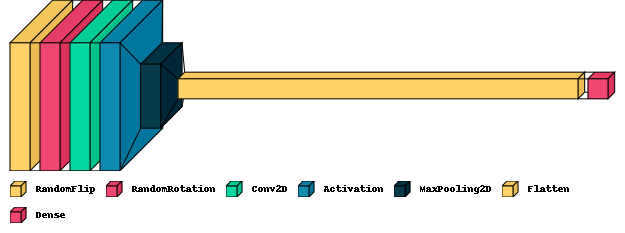

In [24]:
import visualkeras
visualkeras.layered_view(cnn, legend=True)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn.fit(X_train, y_train_ohe, epochs=100, batch_size=128, shuffle=True, 
                      validation_data=(X_test, y_test_ohe), verbose=1, )
                    #   callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/100
32/32 [==============================] - 7s 135ms/step - loss: 1.4550 - accuracy: 0.4980 - val_loss: 1.5708 - val_accuracy: 0.4530
Epoch 2/100
32/32 [==============================] - 2s 68ms/step - loss: 1.4319 - accuracy: 0.4967 - val_loss: 1.5270 - val_accuracy: 0.4540
Epoch 3/100
32/32 [==============================] - 2s 69ms/step - loss: 1.4235 - accuracy: 0.4997 - val_loss: 1.5697 - val_accuracy: 0.4510
Epoch 4/100
32/32 [==============================] - 2s 69ms/step - loss: 1.4266 - accuracy: 0.5023 - val_loss: 1.5822 - val_accuracy: 0.4500
Epoch 5/100
32/32 [==============================] - 2s 67ms/step - loss: 1.4363 - accuracy: 0.5055 - val_loss: 1.6066 - val_accuracy: 0.4320
Epoch 6/100
32/32 [==============================] - 2s 69ms/step - loss: 1.4120 - accuracy: 0.5030 - val_loss: 1.5374 - val_accuracy: 0.4730
Epoch 7/100
32/32 [==============================] - 2s 68ms/step - loss: 1.4219 - accuracy: 0.5075 - val_loss: 1.6079 - val_accuracy: 0.4420
Epoch

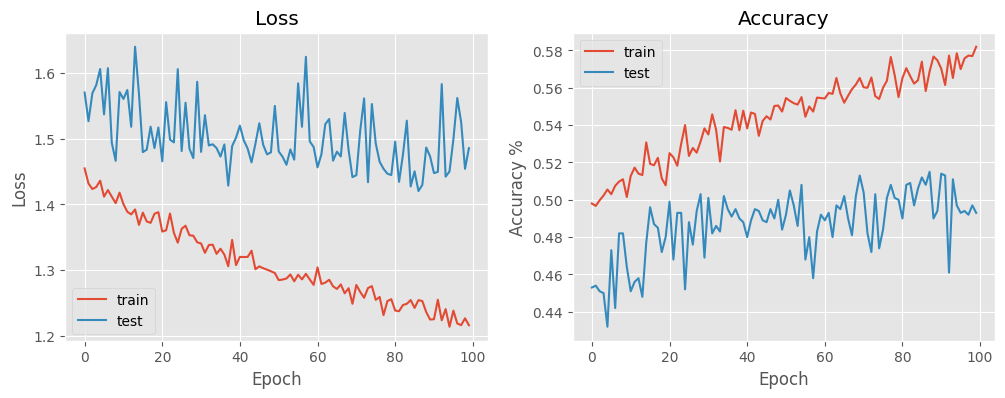

In [30]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()


### CNN Number 2

For our next CNN, we decided to make a lot of upgrades. We have a total of 6 cnn's with batch normalization after each cnn layer. Then after every two cnn's we max pooled and performed dropout. In this one we also ran it through two dense layers instead of one.

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_11 (RandomFlip  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 random_rotation_11 (Random  (None, 32, 32, 3)         0         
 Rotation)                                                       
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_28 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        9248      
                                                              

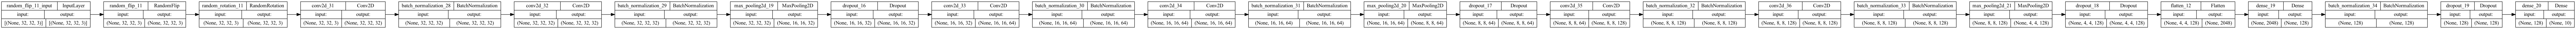

In [83]:
cnn2 = Sequential(name='cnn2')
# Add data augmentation layers
cnn2.add(RandomFlip('horizontal'))
cnn2.add(RandomRotation(0.2))

cnn2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.3))

cnn2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.5))

cnn2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.5))

cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(Dropout(0.5))
cnn2.add(Dense(N_CLASSES, activation='softmax'))

cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn2.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn2.summary())

# Plot the model
plot_model(
    cnn2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

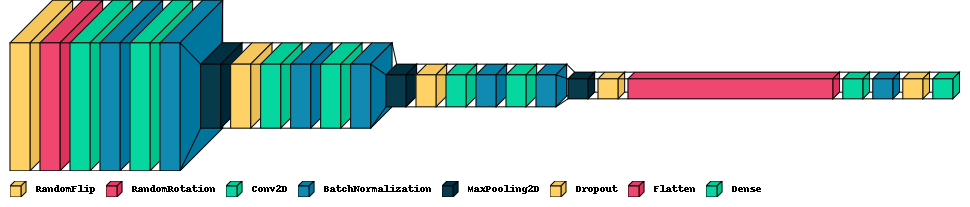

In [84]:
visualkeras.layered_view(cnn2, legend=True)

In [85]:
cnn2_history = cnn2.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True, 
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=7)])

Epoch 1/100
63/63 [==============================] - 19s 190ms/step - loss: 2.7786 - accuracy: 0.2033 - val_loss: 2.7387 - val_accuracy: 0.1040
Epoch 2/100
63/63 [==============================] - 6s 91ms/step - loss: 2.1891 - accuracy: 0.2730 - val_loss: 2.6787 - val_accuracy: 0.1050
Epoch 3/100
63/63 [==============================] - 6s 91ms/step - loss: 2.0002 - accuracy: 0.3097 - val_loss: 3.2612 - val_accuracy: 0.1040
Epoch 4/100
63/63 [==============================] - 6s 93ms/step - loss: 1.8745 - accuracy: 0.3327 - val_loss: 3.0627 - val_accuracy: 0.1190
Epoch 5/100
63/63 [==============================] - 6s 97ms/step - loss: 1.8235 - accuracy: 0.3442 - val_loss: 2.9924 - val_accuracy: 0.1170
Epoch 6/100
63/63 [==============================] - 6s 92ms/step - loss: 1.7494 - accuracy: 0.3695 - val_loss: 2.3955 - val_accuracy: 0.2000
Epoch 7/100
63/63 [==============================] - 6s 90ms/step - loss: 1.7204 - accuracy: 0.3747 - val_loss: 2.1604 - val_accuracy: 0.2470
Epoc

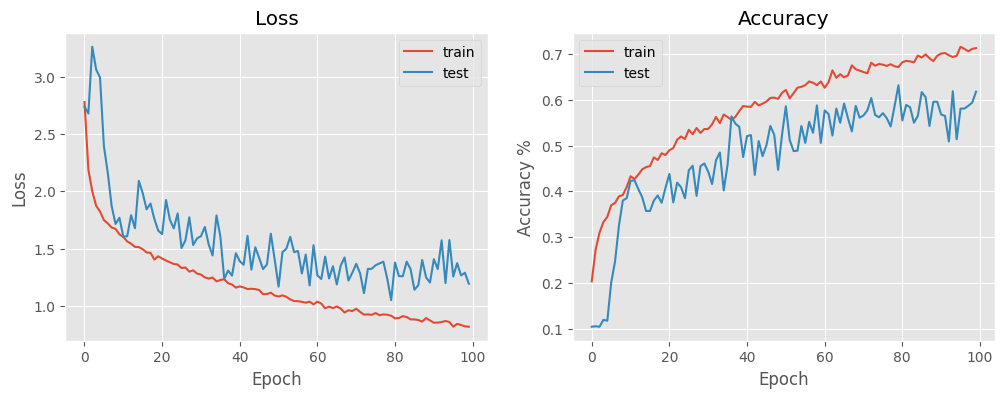

In [86]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn2_history.history['loss'], label='train')
plt.plot(cnn2_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn2_history.history['accuracy'], label='train')
plt.plot(cnn2_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

In [87]:
# Plot confusion matrix for cnn
from sklearn import metrics as mt
import seaborn as sns
def confusion_matrix_compare(model, model2, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15, 5))
    if model is not None:
        yhat = np.argmax(model.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 1)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model.name}: {acc:.3f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    
    if model2 is not None:
        yhat = np.argmax(model2.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 2)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model2.name}: {acc:.3f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

32/32 [==============================] - 2s 23ms/step


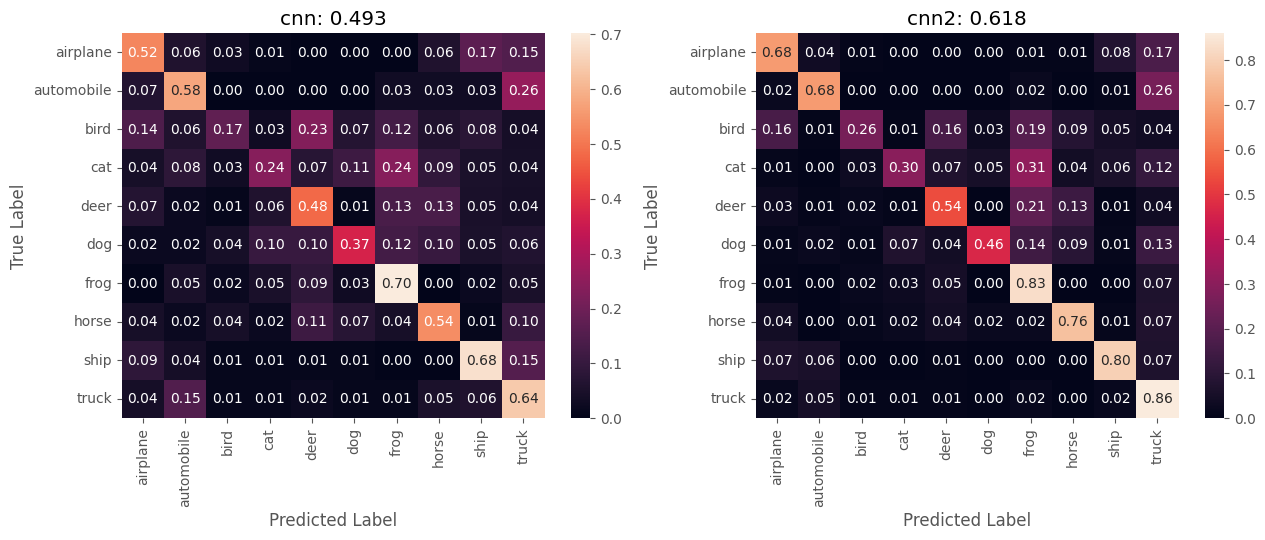

In [88]:
confusion_matrix_compare(cnn, cnn2, X_test, y_test, labels=labels)

### CNN3: CNN 1 with Changed Parameters
In this network we increased the number of filters from 32 to 128. Also we decreased the random roation to 0.1. The batch size was lowered from 128 to 64 and the number of epochs was decreased from 100 to 50.

Model: "cnn3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_8 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_8 (RandomR  (None, 32, 32, 3)         0         
 otation)                                                        
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 activation_6 (Activation)   (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0      

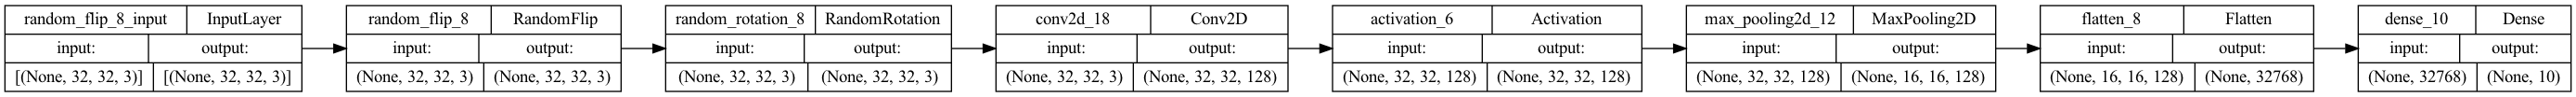

In [49]:
# Define the model
cnn3 = Sequential(name='cnn3')
# Add data augmentation layers
cnn3.add(RandomFlip('horizontal'))
cnn3.add(RandomRotation(0.1))

# Add convolutional layers
cnn3.add(Conv2D(128, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn3.add(Activation('relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn3.add(Flatten())
cnn3.add(Dense(N_CLASSES, activation='softmax'))

# Build the model
cnn3.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
cnn3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(cnn3.summary())

# Plot the model
plot_model(
    cnn3, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

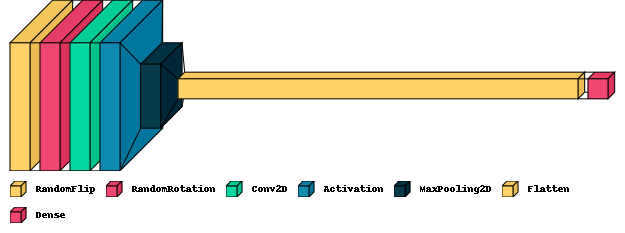

In [50]:
visualkeras.layered_view(cnn3, legend=True)

In [57]:
cnn3_history = cnn3.fit(X_train, y_train_ohe, epochs=50, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/50
63/63 [==============================] - 7s 83ms/step - loss: 1.1543 - accuracy: 0.5953 - val_loss: 1.4563 - val_accuracy: 0.5050
Epoch 2/50
63/63 [==============================] - 5s 74ms/step - loss: 1.1617 - accuracy: 0.5938 - val_loss: 1.3755 - val_accuracy: 0.5310
Epoch 3/50
63/63 [==============================] - 5s 73ms/step - loss: 1.1654 - accuracy: 0.5915 - val_loss: 1.4366 - val_accuracy: 0.5230
Epoch 4/50
63/63 [==============================] - 5s 74ms/step - loss: 1.1635 - accuracy: 0.5872 - val_loss: 1.4767 - val_accuracy: 0.4870
Epoch 5/50
63/63 [==============================] - 5s 73ms/step - loss: 1.1358 - accuracy: 0.6060 - val_loss: 1.5037 - val_accuracy: 0.5090
Epoch 6/50
63/63 [==============================] - 5s 74ms/step - loss: 1.1465 - accuracy: 0.6033 - val_loss: 1.4280 - val_accuracy: 0.5240
Epoch 7/50
63/63 [==============================] - 5s 75ms/step - loss: 1.1071 - accuracy: 0.6152 - val_loss: 1.4169 - val_accuracy: 0.5200
Epoch 8/50
63

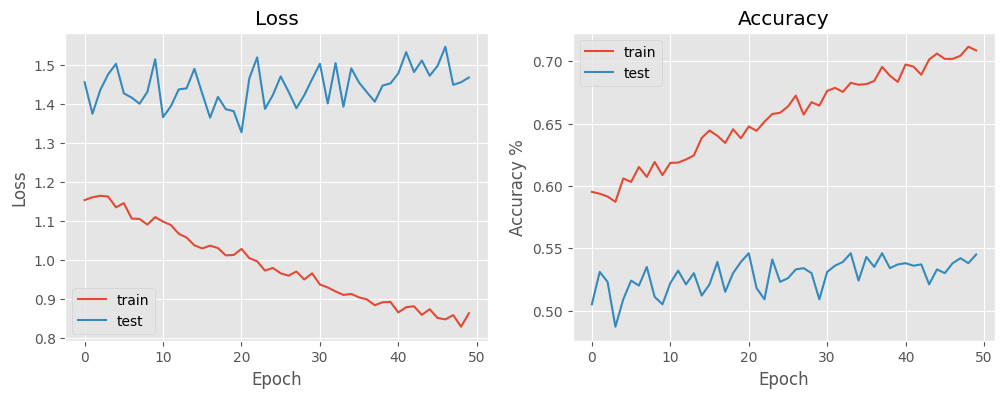

In [58]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn3_history.history['loss'], label='train')
plt.plot(cnn3_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn3_history.history['accuracy'], label='train')
plt.plot(cnn3_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

32/32 [==============================] - 0s 3ms/step


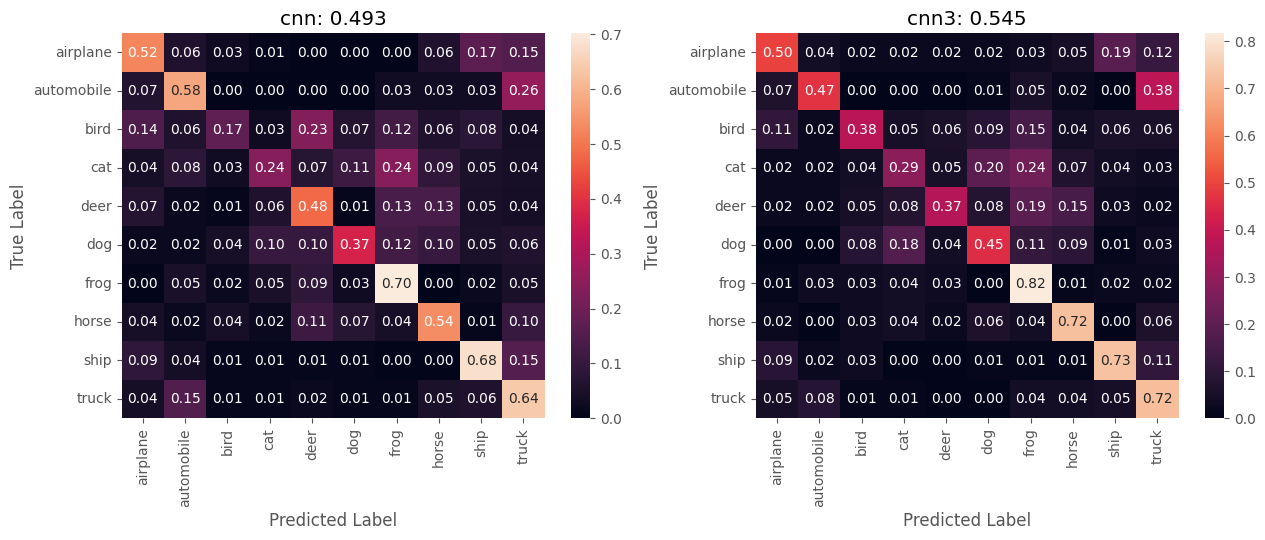

In [59]:
confusion_matrix_compare(cnn, cnn3, X_test, y_test, labels=labels)

## CNN4: CNN2 with Changed Parameters
In this network we increased the size of the filter for the first two cnn's from 3x3 to 5x5. We also increased the number of neurons in the dense layer from 128 to 256.

Model: "cnn4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_10 (RandomFlip  (None, 32, 32, 3)         0         
 )                                                               
                                                                 
 random_rotation_10 (Random  (None, 32, 32, 3)         0         
 Rotation)                                                       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_21 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        9248      
                                                              

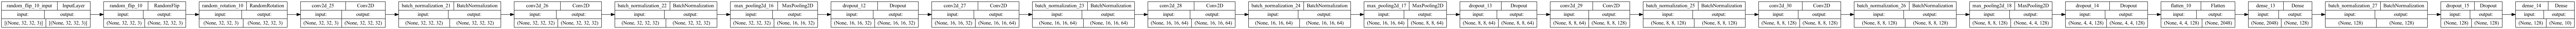

In [60]:
cnn4 = Sequential(name='cnn4')
# Add data augmentation layers
cnn4.add(RandomFlip('horizontal'))
cnn4.add(RandomRotation(0.2))

cnn4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.3))

cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.5))

cnn4.add(Flatten())
cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(N_CLASSES, activation='softmax'))

cnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn4.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(cnn4.summary())

# Plot the model
plot_model(
    cnn4, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

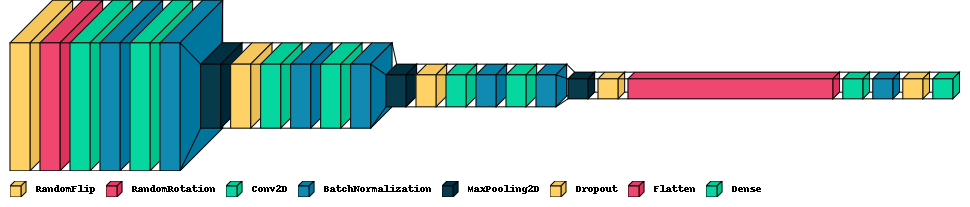

In [61]:
visualkeras.layered_view(cnn4, legend=True)

In [62]:
cnn4_history = cnn4.fit(X_train, y_train_ohe, epochs=100, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1,)
                        # callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
63/63 [==============================] - 20s 187ms/step - loss: 2.7925 - accuracy: 0.2130 - val_loss: 2.8744 - val_accuracy: 0.1040
Epoch 2/100
63/63 [==============================] - 6s 88ms/step - loss: 2.1916 - accuracy: 0.2735 - val_loss: 3.2136 - val_accuracy: 0.1040
Epoch 3/100
63/63 [==============================] - 5s 87ms/step - loss: 2.0006 - accuracy: 0.3065 - val_loss: 3.0985 - val_accuracy: 0.1040
Epoch 4/100
63/63 [==============================] - 5s 87ms/step - loss: 1.8608 - accuracy: 0.3345 - val_loss: 2.9871 - val_accuracy: 0.1200
Epoch 5/100
63/63 [==============================] - 5s 86ms/step - loss: 1.8231 - accuracy: 0.3453 - val_loss: 2.9506 - val_accuracy: 0.1270
Epoch 6/100
63/63 [==============================] - 5s 86ms/step - loss: 1.7545 - accuracy: 0.3747 - val_loss: 2.8801 - val_accuracy: 0.1440
Epoch 7/100
63/63 [==============================] - 5s 87ms/step - loss: 1.7389 - accuracy: 0.3623 - val_loss: 2.3796 - val_accuracy: 0.2130
Epoc

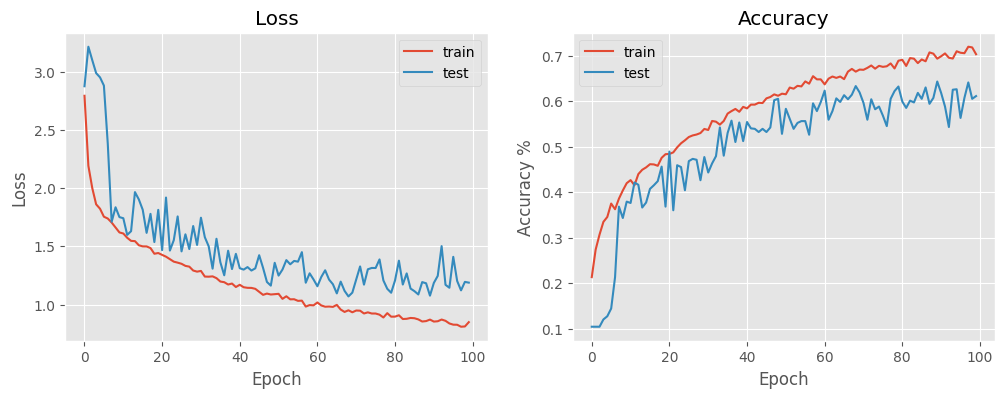

In [63]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn4_history.history['loss'], label='train')
plt.plot(cnn4_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn4_history.history['accuracy'], label='train')
plt.plot(cnn4_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

32/32 [==============================] - 1s 19ms/step


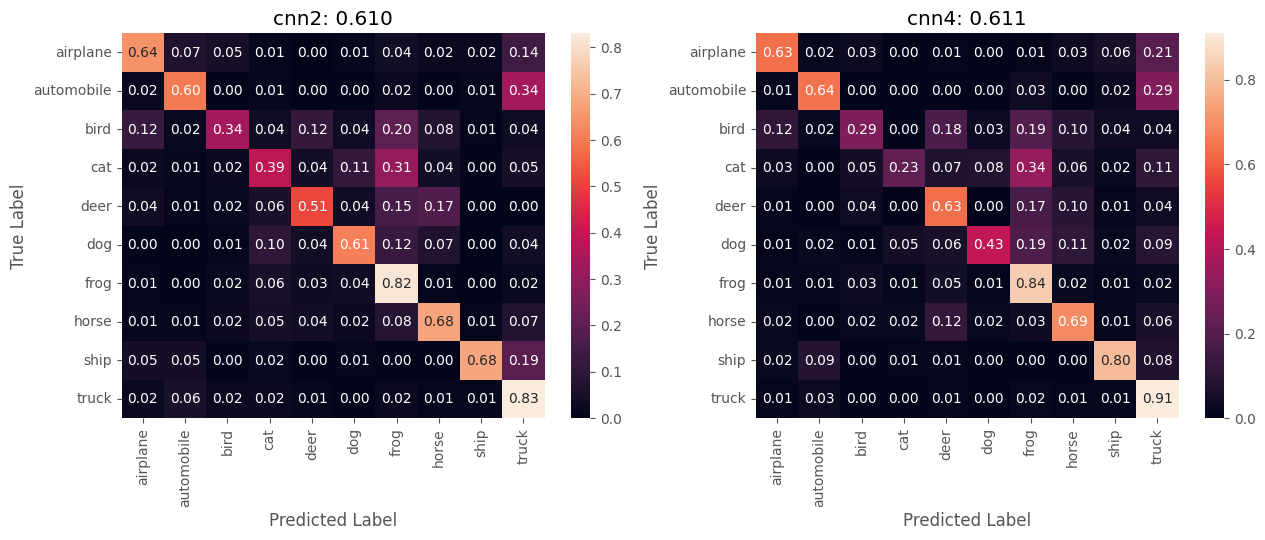

In [64]:
confusion_matrix_compare(cnn2, cnn4, X_test, y_test, labels=labels)

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 3072)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               1573376   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 10)                1290      
                                                                 
Total params: 1738890 (6.63 MB)
Trainable params: 1738890 (6.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


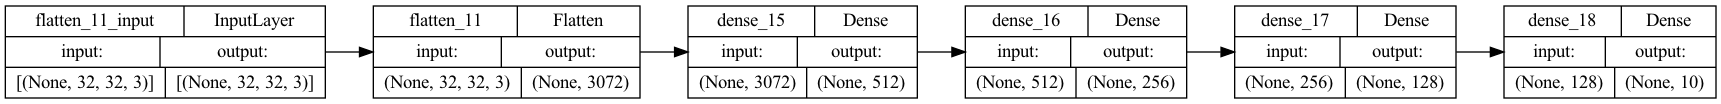

In [65]:
# baseline MLP model

mlp = Sequential(name='mlp')
mlp.add(Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dense(256, activation='relu'))
mlp.add(Dense(128, activation='relu'))
mlp.add(Dense(N_CLASSES, activation='softmax'))

mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# mlp.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

print(mlp.summary())

plot_model(
    mlp, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [68]:
mlp_history = mlp.fit(X_train, y_train_ohe, epochs=50, batch_size=64, shuffle=True,
                        validation_data=(X_test, y_test_ohe), verbose=1)

Epoch 1/50
63/63 [==============================] - 4s 63ms/step - loss: 2.2012 - accuracy: 0.2625 - val_loss: 2.5894 - val_accuracy: 0.2280
Epoch 2/50
63/63 [==============================] - 4s 61ms/step - loss: 2.2266 - accuracy: 0.2650 - val_loss: 2.2220 - val_accuracy: 0.2430
Epoch 3/50
63/63 [==============================] - 4s 64ms/step - loss: 2.7897 - accuracy: 0.2292 - val_loss: 3.7635 - val_accuracy: 0.2210
Epoch 4/50
63/63 [==============================] - 4s 64ms/step - loss: 2.5819 - accuracy: 0.2488 - val_loss: 2.6114 - val_accuracy: 0.2330
Epoch 5/50
63/63 [==============================] - 4s 65ms/step - loss: 2.3095 - accuracy: 0.2607 - val_loss: 2.2839 - val_accuracy: 0.2530
Epoch 6/50
63/63 [==============================] - 4s 65ms/step - loss: 3.0564 - accuracy: 0.2202 - val_loss: 3.1005 - val_accuracy: 0.1760
Epoch 7/50
63/63 [==============================] - 4s 62ms/step - loss: 3.0150 - accuracy: 0.2243 - val_loss: 3.3763 - val_accuracy: 0.2440
Epoch 8/50
63

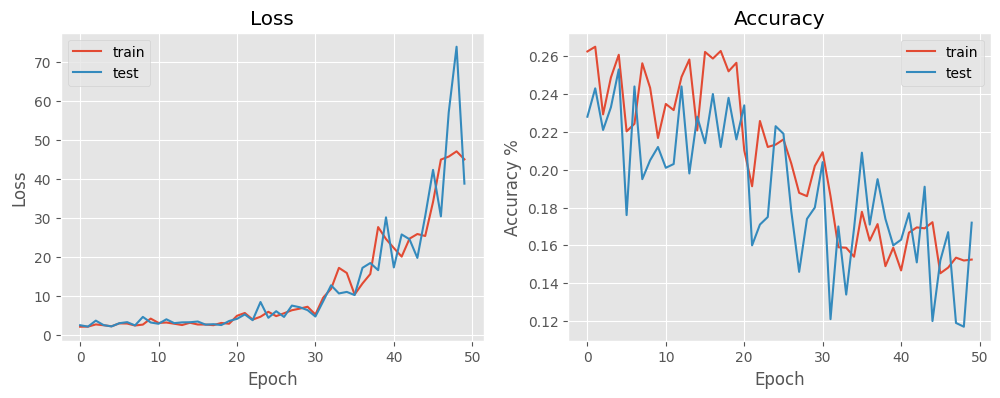

In [69]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='train')
plt.plot(mlp_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['accuracy'], label='train')
plt.plot(mlp_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

32/32 [==============================] - 0s 8ms/step


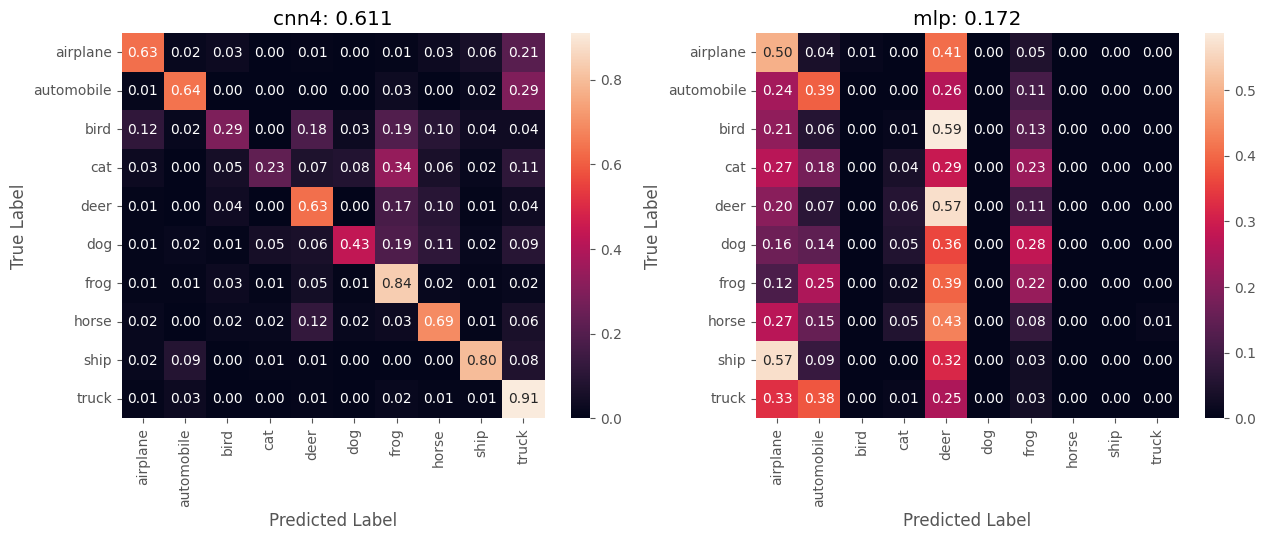

In [70]:
confusion_matrix_compare(cnn4, mlp, X_test, y_test, labels=labels)

### Micro-Average ROC curve and AUC

32/32 [==============================] - 0s 3ms/step


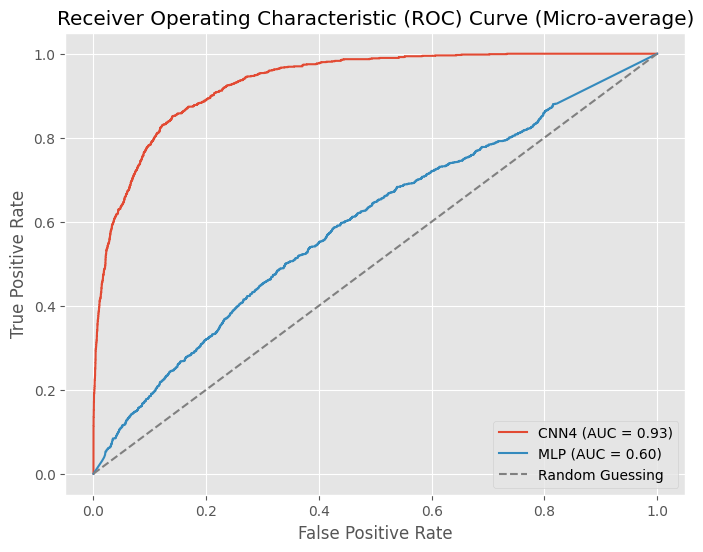

In [81]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import roc_curve, auc

yhat_cnn4 = cnn4.predict(X_test)
yhat_mlp = mlp.predict(X_test)

y_true = y_test.ravel()

y_test_bin = label_binarize(y_true, classes=np.arange(N_CLASSES))  

cnn4_fpr = dict()
cnn4_tpr = dict()
cnn4_roc_auc = dict()

mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()

for i in range(N_CLASSES):
    cnn4_fpr[i], cnn4_tpr[i], _ = roc_curve(y_test_bin[:, i], yhat_cnn4[:, i])
    cnn4_roc_auc[i] = auc(cnn4_fpr[i], cnn4_tpr[i])

    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(y_test_bin[:, i], yhat_mlp[:, i])
    mlp_roc_auc[i] = auc(mlp_fpr[i], mlp_tpr[i])

# Compute micro-average ROC curve and ROC area
cnn4_fpr['micro'], cnn4_tpr['micro'], _ = roc_curve(y_test_bin.ravel(), yhat_cnn4.ravel())
cnn4_roc_auc['micro'] = auc(cnn4_fpr['micro'], cnn4_tpr['micro'])

mlp_fpr['micro'], mlp_tpr['micro'], _ = roc_curve(y_test_bin.ravel(), yhat_mlp.ravel())
mlp_roc_auc['micro'] = auc(mlp_fpr['micro'], mlp_tpr['micro'])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(cnn4_fpr['micro'], cnn4_tpr['micro'], label=f'CNN4 (AUC = {cnn4_roc_auc["micro"]:.2f})')
plt.plot(mlp_fpr['micro'], mlp_tpr['micro'], label=f'MLP (AUC = {mlp_roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Micro-average)')
plt.legend()
plt.grid(True)
plt.show()